# Analysis of the Speed Dating Experiment

Group Members:
* Yunya Wang, yw4509
* Yihang Zhang, yz2865
* Chuan Chen, cc6580

Member responsible for uploading submissions: 
* Yunya Wang

# Abstract


The project is focused on using classication algorithms to find the contributing factors of speed dating that will lead to a second date. We are also interested in seeing if those factors differ based on the participant’s gender and race. The data we  use is compiled by Columbia Business School professors Ray Fisman and Sheena Iyengar for their paper “Gender Differences in Mate Selection: Evidence From a Speed Dating Experiment.” We first conducted data exploration and cleaning on the original data set. Then we completed the feature engineering to re-construct it into a dataset containing 7 important features that might have important influcence on the result. After applying Logistic Regression, Decision Tree and XGBoosting, we selected the Decision Tree model as our preferred model due to its best performance. The conclusion is that the 3 most influential contributing factors of speed dating success are rating, financial difference and experience difference.

# Background

The success of date matching has long been one of the mostly studied social topics. Many efforts have been put into studying exactly what leads to a successful match between two potential partners. Speed dating is one of the most well-established form of potential match-making that millions of people in the United States have participated in. Our project aims to study different attributes such as preferences in partners which impacts the success of speed dating.

For our project, we are using data from a speed dating experiment conducted from 2002 to 2004 [1]. The experimental design is based on meetings through Speed
Dating, in which participants engage in four-minute conversations to determine whether or not they are interested in meeting each other again. If both people “accept,” then a match is made between them. Before and after each date, participants filled out questionnaires answering various profile questions and evaluation of their partners. We will be studying the response of those questions and their impact of the success of speed dating. We hope that our results can help provide more insight into what influences love at first sight. 

## References

1. Fisman, R., et al. “Gender Differences in Mate Selection: Evidence From a Speed Dating Experiment.” The Quarterly Journal of Economics, vol. 121, no. 2, 2006, pp. 673–697., doi:10.1162/qjec.2006.121.2.673.

2. Montoya, Anna. “Speed Dating Experiment.” Kaggle, 2015, www.kaggle.com/annavictoria/speed-dating-experiment.

# Results

### Description of Methodology

We hope to build and train supervised learning models with the target variable of whether or not a speed date resulted in a match or not. There are more than 100 features in total ranging from the goal of dating, personal habits, gender, age, race, the field of study, income and many other attributes. From these variables, we will perform data cleaning to prepare data sets for training, conduct exploratory data analysis to understand the data distributions, calculate correlation between variables, and possibly create a new features to further enhance the predictability of the model. Then we will find appropriate models to fit the data including hyperparameter tuning through cross-validation and model performances testing through metrics such as AUC. We are interested mainly in three different models, Logistic Regression, Decision Tree, and Xgboost.

Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables. This regression uses the logistic function and can map the probability of the success/fail of the speed date based on different attributes. The ease of implementation makes logistic regression the go-to method for binary classification problems.

A decision tree is a flowchart-like structure in which each internal node represents a “test” on an attribute, such as whether the gender of the participant is male or female, each branch that stems out from a node represents the outcome of the test, and each leaf node (the terminal node in the chart) represents a class label, which is the decision taken after computing all attributes. The paths from the root to the leaf represent classification rules. Tree-based learning algorithms are recognized to be one of the most reliable and mostly used supervised learning methods. Tree-based methods grant predictive models with great accuracy, stability, and ease of interpretation. Through the modeling process, the information gain of each attribute can also be calculated which can give us an idea of what attributes affects the success of speed dating the most. 

Xgboost is widely used machine learning package elaborate bagging on weak learners and boosting on the errors. It has more parameters to tune than the standard tree models and thus more prone to overfitting. Thus extra caution needs to be taken in the cross validation process. This package is very powerful and widely used by many data scientists in boh kaggle competition and work. We will compare this model with logistic regression and decision tree in the end.

## Experiments and Evaluation

###Data Analysis

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 1000 #handy for showing truncated results
%matplotlib inline

In [0]:
# importing packages
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score

####**Predefined Function**

In [0]:
#function for getting the distribution of the categorical features
def get_categ_features_counts_dataframe(df,col_name):
    temp = df.groupby(col_name).agg({col_name:['count']})
    temp.columns = temp.columns.droplevel(0)
    temp = temp.sort_values(["count"],ascending=False)
    print('There are %d levels' % len(temp))
    return temp

In [0]:
def plot_histogram(df, var):
  plt.hist(df[~df[var].isnull()][var].values)
  plt.xlabel(var)
  plt.ylabel('Frequency')
  plt.xticks(rotation=90)

In [0]:
def plot_histogram_by_cate(df,var,cate):
  g = sns.FacetGrid(df, hue=cate, height = 6)
  g.map(plt.hist, var, alpha= 0.7, bins=20)
  g.set_xlabels(var, fontsize=12)
  plt.subplots_adjust(top=0.9)
  g.fig.suptitle(var +' distribution by '+cate, fontsize=15)
  g.add_legend()

In [0]:
def many_hist(df,cols):
    num = len(cols)
    rows = int(num/2) + (num % 2 > 0)
    fig, ax = plt.subplots(rows, 2, figsize=(15, 5 * (rows)))
    i = 0
    j = 0
    for feat in cols:
        df[feat].hist(label=feat, ax=ax[i][j])
        ax[i][j].set_title(feat, fontsize=12)
        ax[i][j].grid(False)
        j = (j+1)%2
        i = i + 1 - j

In [0]:
def str_to_float(series):
    return series.apply(lambda x: str(x).replace(",", "")).astype('float64')  #2,300 => 2300

In [0]:
# standardize features 1, z-score
def standardize_feature(series):
    return (series - series.mean()) / series.std(ddof=0)

# standardize features 2, std=1, remain the mean
def standardize_feature_2(series):
    return (series) / series.std(ddof=0)

**Read the raw file using encoding "ISO-8859-1"**

In [0]:
file_path = 'drive/My Drive/1007Project/Speed Dating Data.csv'
df_raw = pd.read_csv(file_path,encoding = "ISO-8859-1")
print ("Data is loaded!")

Data is loaded!


In [0]:
df_raw.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,1,11.0,0,0.14,0,27.0,2.0,35.0,20.0,20.0,20.0,0.0,5.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,2,12.0,0,0.54,0,22.0,2.0,60.0,0.0,0.0,40.0,0.0,0.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,3,13.0,1,0.16,1,22.0,4.0,19.0,18.0,19.0,18.0,14.0,12.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,4,14.0,1,0.61,0,23.0,2.0,30.0,5.0,15.0,40.0,5.0,5.0,1,7.0,8.0,9.0,8.0,9

#### Data Exploration Analysis

**1. Understand the fields**

In [0]:
print ("Number of rows: ",df_raw.shape[0],"and Number of features ",df_raw.shape[1])
print("Column Names: \n",np.array(list(df_raw.columns)))

Number of rows:  8378 and Number of features  195
Column Names: 
 ['iid' 'id' 'gender' 'idg' 'condtn' 'wave' 'round' 'position' 'positin1'
 'order' 'partner' 'pid' 'match' 'int_corr' 'samerace' 'age_o' 'race_o'
 'pf_o_att' 'pf_o_sin' 'pf_o_int' 'pf_o_fun' 'pf_o_amb' 'pf_o_sha' 'dec_o'
 'attr_o' 'sinc_o' 'intel_o' 'fun_o' 'amb_o' 'shar_o' 'like_o' 'prob_o'
 'met_o' 'age' 'field' 'field_cd' 'undergra' 'mn_sat' 'tuition' 'race'
 'imprace' 'imprelig' 'from' 'zipcode' 'income' 'goal' 'date' 'go_out'
 'career' 'career_c' 'sports' 'tvsports' 'exercise' 'dining' 'museums'
 'art' 'hiking' 'gaming' 'clubbing' 'reading' 'tv' 'theater' 'movies'
 'concerts' 'music' 'shopping' 'yoga' 'exphappy' 'expnum' 'attr1_1'
 'sinc1_1' 'intel1_1' 'fun1_1' 'amb1_1' 'shar1_1' 'attr4_1' 'sinc4_1'
 'intel4_1' 'fun4_1' 'amb4_1' 'shar4_1' 'attr2_1' 'sinc2_1' 'intel2_1'
 'fun2_1' 'amb2_1' 'shar2_1' 'attr3_1' 'sinc3_1' 'fun3_1' 'intel3_1'
 'amb3_1' 'attr5_1' 'sinc5_1' 'intel5_1' 'fun5_1' 'amb5_1' 'dec' 'attr'
 'sinc' '

**2. Map some of the numeric variables to categorical features**

In [0]:
df_0 = df_raw.copy()

In [0]:
df_0["race_cate"] = df_0["race"].\
map({1: 'Black', 2: 'White', 3: 'Hispanic', 4: 'Asian', 5:'Native_American',6: 'Other'}).fillna('Other')

In [0]:
df_0['field_cd_cate'] = df_0['field_cd'].\
map({1: 'Law', 2: 'Math', 3: 'Soc. Sc.', 4: 'Med. Sc.',
             5: 'Eng.', 6: 'Journ.', 7: 'Hist.', 8: 'Econ', 9: 'Educ.',
             10: 'Nat. Sc.', 11: 'Soc. Wr.', 12: 'Und.', 13: 'Pol. Sc.',
             14: 'Film', 15: 'Arts', 16:'Lang.', 17: 'Arch.', 18: 'Oth.'}).fillna('Oth.')

In [0]:
df_0["gender"] = df_0["gender"].map({0:'Female',1:'Male'}).fillna('Other')

In [0]:
df_0["goal"] = df_0["goal"].\
map({1: 'Fun', 2: 'Meet', 3: 'Date', 4: 'Relationship', 5: 'IdidIt', 6: 'Other'}).fillna('Other')

In [0]:
df_0['go_out_cate'] = df_0.go_out.map({1: 'Several_pw', 2: 'Twice_pw', 3: 'Once_pw',
                             4: 'Twice_pm', 5: 'Once_pm', 6: 'Several_py',
                             7: 'Almost_never'}).fillna('Other')

**3. We could split the features into different buckets**

In [0]:
Data_key = ['iid','id','gender','idg','condtn','wave','round','position','positin1','order','partner','pid','match','int_corr',
            'samerace','age_o','race_o','pf_o_att','dec_o','attr_o']
quant_var = [f for f in df_0.columns if df_0.dtypes[f] != 'object']
cate_var = [f for f in df_0.columns if df_0.dtypes[f] == 'object']

In [0]:
personal = ['gender', 'age', 'field', 'field_cd','field_cd_cate', 'undergra',
       'mn_sat', 'tuition', 'race', "race_cate" ,'imprace', 'imprelig', 'from',
       'zipcode', 'income', 'goal', 'date', 'go_out','go_out_cate', 'career',
       'career_c', 'sports', 'tvsports', 'exercise', 'dining', 'museums',
       'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater',
       'movies', 'concerts', 'music', 'shopping', 'yoga', 'exphappy',
       'expnum','match_es']
decision = ['match','dec',
       'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob',
       'met']
evaluation = ['satis_2', 'length', 'numdat_2']
outcome = ['you_call', 'them_cal', 'date_3', 'numdat_3',
       'num_in_3']

**4. Analysis of dataset**

Before we begin, it is important to notice that each participants is in the DataFrame multiple times, once for each potential match. Thus an exploratory analysis on this dataset would be on 8378 individuals with many many repetitions.

In other words, if I am person A and I participate to a wave with 10 participants of the opposite gender, for which I have particpate in 10 different dates with, I count as 10 person A's. This can bias the analysis and therefore I want to create a second DataFrame with only the unique entries, giving us the real number of participants: 551.

In [0]:
#this df is mainly for understanding the data and interactions between features, thus we only keep the unique iid and wave
df_temp = df_0[['iid', 'wave'] + personal + evaluation + outcome].drop_duplicates().copy()
df_temp.head()

,iid,wave,gender,age,field,field_cd,field_cd_cate,undergra,mn_sat,tuition,race,race_cate,imprace,imprelig,from,zipcode,income,goal,date,go_out,go_out_cate,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,match_es,satis_2,length,numdat_2,you_call,them_cal,date_3,numdat_3,num_in_3
0,1,1,Female,21.0,Law,1.0,Law,NaN,NaN,NaN,4.0,Asian,2.0,4.0,Chicago,"60,521","69,487.00",Meet,7.0,1.0,Several_pw,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,4.0,6.0,2.0,1.0,1.0,1.0,0.0,NaN,NaN
10,2,1,Female,24.0,law,1.0,Law,NaN,NaN,NaN,2.0,White,2.0,5.0,Alabama,"35,223","65,929.00",Fun,5.0,1.0,Several_pw,law,NaN,3.0,2.0,7.0,10.0,8.0,6.0,3.0,5.0,8.0,10.0,1.0,9.0,8.0,7.0,8.0,3.0,1.0,4.0,5.0,3.0,5.0,2.0,NaN,0.0,0.0,0.0,NaN,NaN
20,3,1,Female,25.0,Economics,2.0,Math,NaN,NaN,NaN,2.0,White,8.0,4.0,Connecticut,"6,268",NaN,Other,3.0,1.0,Several_pw,Economist,NaN,3.0,8.0,7.0,8.0,5.0,5.0,8.0,4.0,5.0,7.0,8.0,7.0,7.0,7.0,5.0,8.0,7.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,4,1,Female,23.0,Law,1.0,Law,NaN,NaN,NaN,2.0,White,1.0,1.0,Texas,"77,096","37,754.00",Fun,5.0,1.0,Several_pw,lawyer/policy work,1.0,1.0,1.0,6.0,7.0,6.0,7.0,7.0,5.0,7.0,7.0,7.0,9.0,7.0,8.0,7.0,1.0,8.0,1.0,2.0,2.0,4.0,3.0,2.0,0.0,0.0,0.0,NaN,NaN
40,5,1,Female,21.0,Law,1.0,Law,NaN,NaN,NaN,2.0,White,8.0,1.0,Bowdoin College,"94,022","86,340.00",Meet,4.0,1.0,Several_pw,lawyer,1.0,7.0,4.0,7.0,7.0,6.0,8.0,6.0,6.0,8.0,6.0,8.0,6.0,6.0,3.0,7.0,8.0,3.0,7.0,10.0,NaN,7.0,2.0,2.0,0.0,0.0,0.0,NaN,NaN


It looks like only about 20% of people found themselves a second date after the speed dating session!

In [0]:
get_categ_features_counts_dataframe(df_temp,'wave')

There are 21 levels


,count
wave,
21,44
11,42
9,40
14,38
15,37
4,36
2,35
7,32
19,30


In [0]:
# gender dsitribution
get_categ_features_counts_dataframe(df_temp,'gender')

There are 2 levels


,count
gender,
Male,277
Female,274


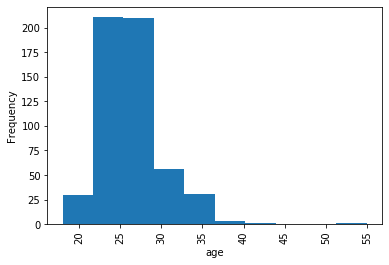

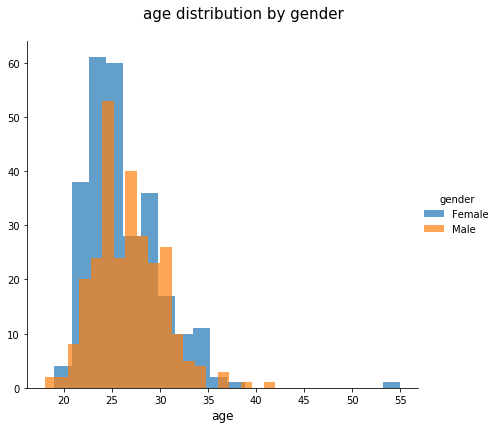

In [0]:
#age distribution, female is generally yonger than males
plot_histogram(df_temp,'age')
plot_histogram_by_cate(df_temp,'age','gender')

In [0]:
get_categ_features_counts_dataframe(df_temp,'race_cate')

There are 5 levels


,count
race_cate,
White,304
Asian,136
Other,43
Hispanic,42
Black,26


There are 18 levels


,count
field_cd_cate,
Econ,130
Nat. Sc.,61
Eng.,56
Law,48
Pol. Sc.,46
Soc. Sc.,46
Educ.,40
Soc. Wr.,30
Journ.,21


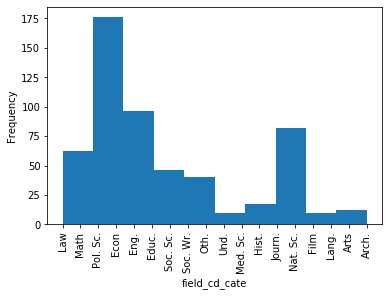

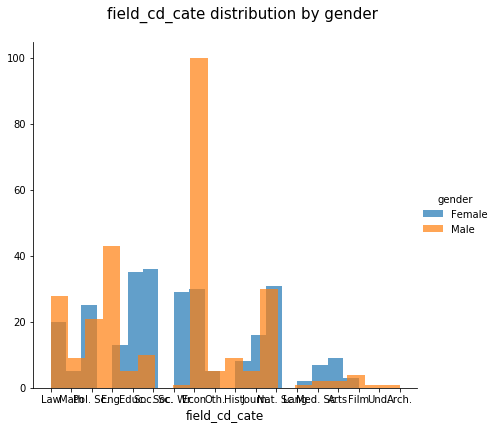

In [0]:
display(get_categ_features_counts_dataframe(df_temp,'field_cd_cate'))
plot_histogram(df_temp,'field_cd_cate')
plot_histogram_by_cate(df_temp,'field_cd_cate','gender')

In [0]:
print('Rate of positive feedback on the partner of the same race, by race')
temp = df_0[['dec','samerace', 'race_cate']].groupby(['race_cate','samerace']).mean()*100
temp.groupby(level=0).apply(lambda x: x / float(x.sum()))

Rate of positive feedback on the partner of the same race, by race


dec
race_cate samerace          
Asian     0         0.517219
          1         0.482781
Black     0         0.388925
          1         0.611075
Hispanic  0         0.453337
          1         0.546663
Other     0         0.514197
          1         0.485803
White     0         0.438341
          1         0.561659

In [0]:
print('Rate of positive feedback on the partner of the same race, by gender')
temp = df_0[['dec','samerace', 'gender']].groupby(['gender','samerace']).mean()*100
temp.groupby(level=0).apply(lambda x: x / float(x.sum()))

Rate of positive feedback on the partner of the same race, by gender


dec
gender samerace          
Female 0         0.468900
       1         0.531100
Male   0         0.499634
       1         0.500366

In [0]:
df_0['goal'].unique()

array(['Meet', 'Fun', 'Other', 'Date', 'Relationship', 'IdidIt'],
      dtype=object)

There are 6 levels


,count
goal,
Fun,228
Meet,189
Date,40
Other,37
IdidIt,35
Relationship,22


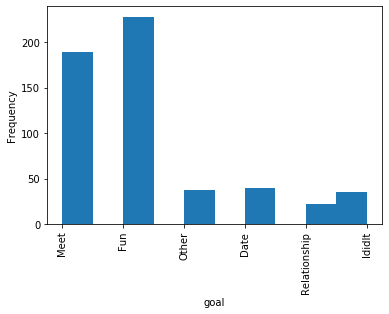

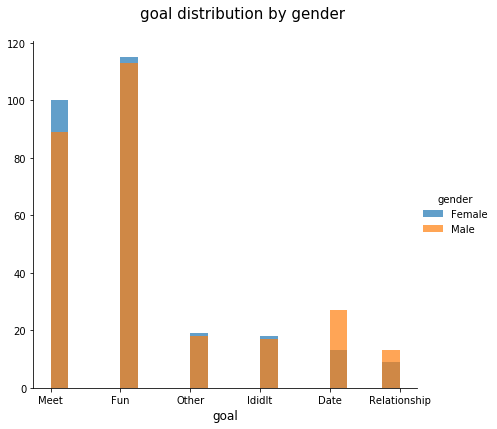

In [0]:
display(get_categ_features_counts_dataframe(df_temp,'goal'))
plot_histogram(df_temp,'goal')
plot_histogram_by_cate(df_temp,'goal','gender')

There are 8 levels


,count
go_out_cate,
Twice_pw,191
Several_pw,177
Once_pw,127
Twice_pm,29
Once_pm,12
Other,7
Several_py,6
Almost_never,2


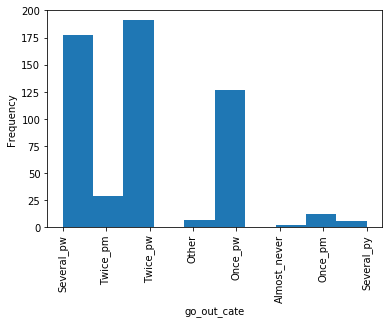

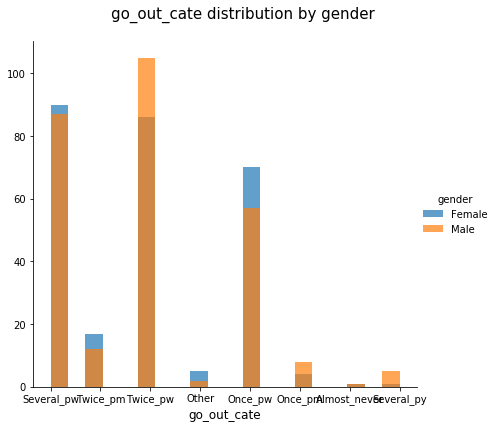

In [0]:
display(get_categ_features_counts_dataframe(df_temp,'go_out_cate'))
plot_histogram(df_temp,'go_out_cate')
plot_histogram_by_cate(df_temp,'go_out_cate','gender')

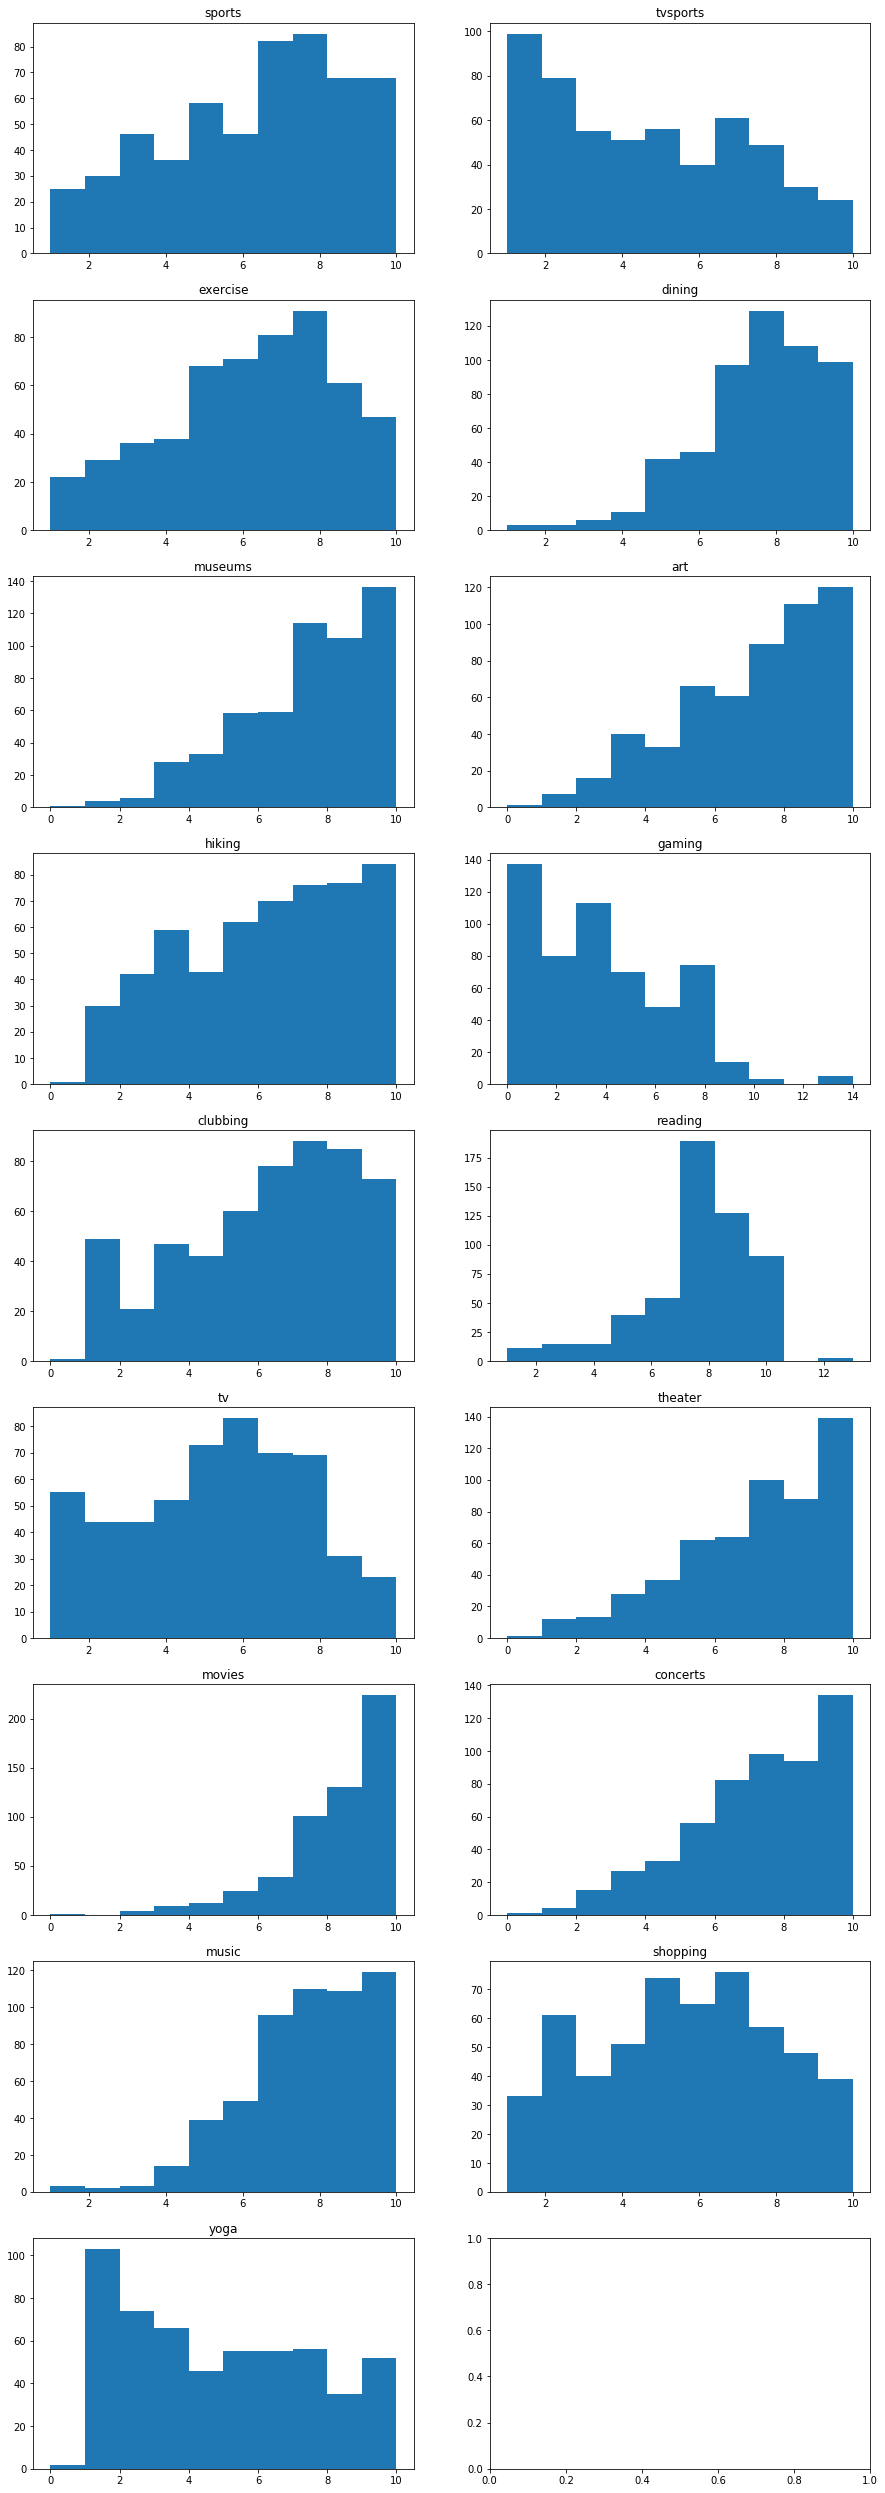

In [0]:
interests = ['sports', 'tvsports', 'exercise', 'dining', 'museums',
       'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater',
       'movies', 'concerts', 'music', 'shopping', 'yoga']
many_hist(df_temp,interests)

Text(0.5, 1, 'Correlation between interests')

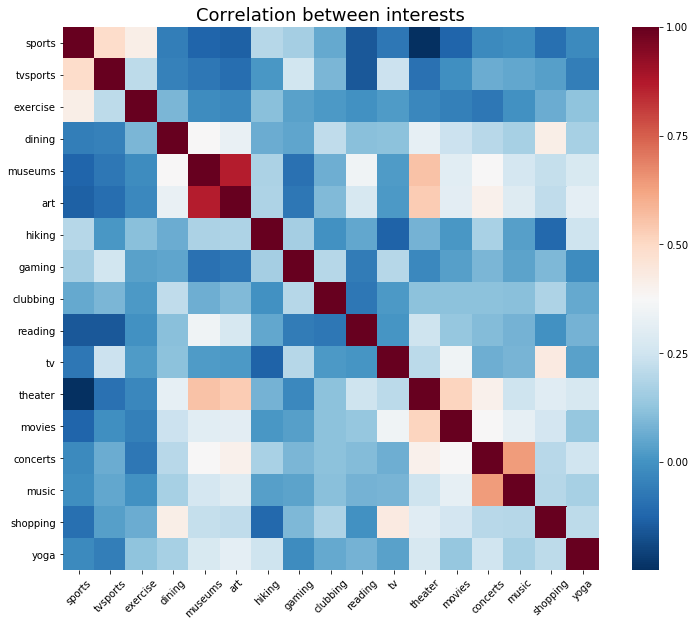

In [0]:
corr = df_temp[interests].corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(corr, cmap='RdBu_r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('Correlation between interests', fontsize=18)
#not much going on here

Text(0.5, 1, 'Females')

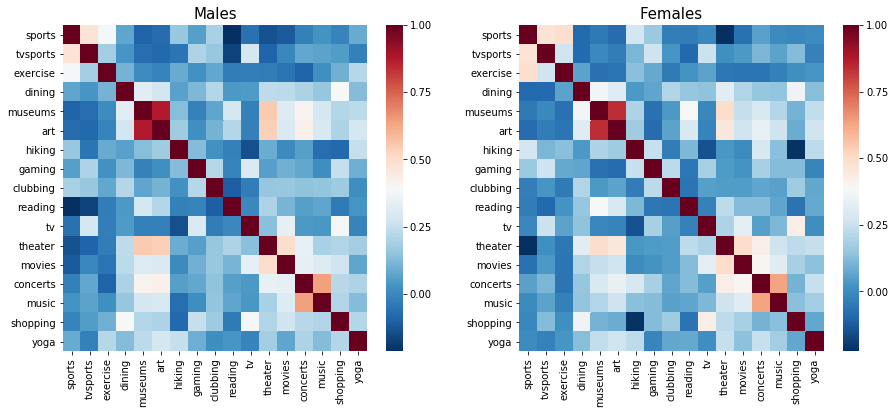

In [0]:
corr_m = df_temp[df_temp.gender=='Male'][interests].corr()
corr_f = df_temp[df_temp.gender=='Female'][interests].corr()

fig, ax= plt.subplots(1,2, figsize=(15, 6))
sns.heatmap(corr_m, cmap='RdBu_r', ax=ax[0])
sns.heatmap(corr_f, cmap='RdBu_r', ax=ax[1])

ax[0].set_title('Males', fontsize=15)
ax[1].set_title('Females', fontsize=15)

exphappy                        
            mean median  min   max count
gender                                  
Female  5.179104    5.0  1.0  10.0   268
Male    5.850909    6.0  1.0  10.0   275

In genderal, male is more optimistic about evening


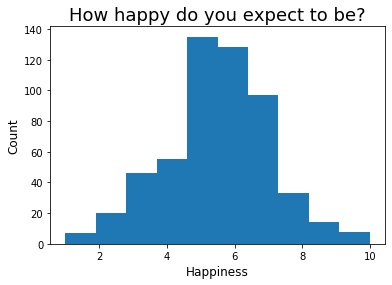

In [0]:
ax = df_temp.exphappy.hist(bins=10, figsize=(6,4))
ax.set_title('How happy do you expect to be?', fontsize=18)
ax.set_xlabel('Happiness',fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(False)
display(df_temp[['gender', 'exphappy']].groupby(['gender']).agg(['mean', 'median', 'min', 'max', 'count']))
print('In genderal, male is more optimistic about evening')

expnum                        
            mean median  min   max count
gender                                  
Female  5.870968    4.0  0.0  20.0    62
Male    5.906250    4.0  0.0  20.0    64

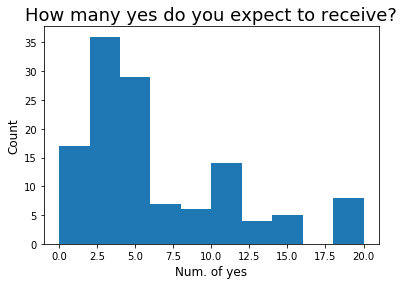

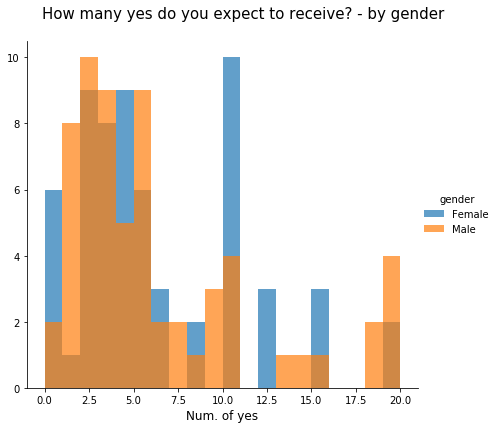

In [0]:
ax = df_temp.expnum.hist(bins=10, figsize=(6,4))
ax.set_title('How many yes do you expect to receive?', fontsize=18)
ax.set_xlabel('Num. of yes',fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(False)
display(df_temp[['gender', 'expnum']].groupby(['gender']).agg(['mean', 'median', 'min', 'max', 'count']))
g = sns.FacetGrid(df_temp, hue='gender', height = 6)
g.map(plt.hist, 'expnum', alpha= 0.7, bins=20)
g.set_xlabels('Num. of yes', fontsize=12)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('How many yes do you expect to receive? - by gender', fontsize=15)
g.add_legend()
#There is no much difference in the averages, 
#but it is easy to notice that a much larger proportion of males are very very confident 
#while Females are more common in expecting a 50/50 success rate.

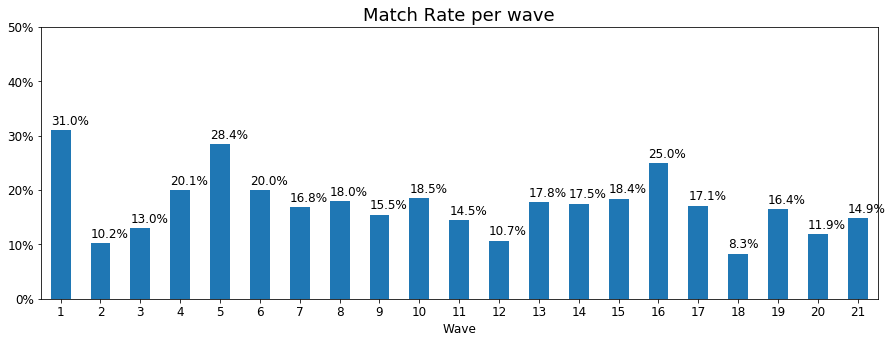

In [0]:
ax = df_0[['wave', 'match']].groupby('wave').mean().plot(kind='bar', legend=False, figsize=(15,5),ylim=(0,0.5))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation='horizontal')
ax.set_xlabel('Wave', fontsize=12)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=12)

ax.set_title('Match Rate per wave', fontsize=18)

for i in ax.patches:
    ax.text(i.get_x(), i.get_height()+.01, \
            str(round((i.get_height())*100, 1))+'%', fontsize=12)

#### **Feature Engineering**

######Add New Features

In [0]:
data_df = df_0.copy()

The dataset consists data from a total of 21 speed dating sessions conducted by the researchers [1]. However, 7 of those sessions were conducted with a different design than the rest for special case studies. Thus, we have to omit those 7 sessions to hopefully avoid some bias in the data.

In [0]:
# since 7 waves are biased, delete them and only keep 14 waves
mask = data_df['wave'].isin([1,2,3,4,5,7,8,9,10,11,13,14,15,17])
data_df = data_df[mask]
data_df['wave'].unique()

array([ 1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 13, 14, 15, 17])

There are 180 variables with NaN
90 variables have more than 0.2 missing values out of 6266 rows
Thus we are going to drop variables with more than 0.2 NaNs


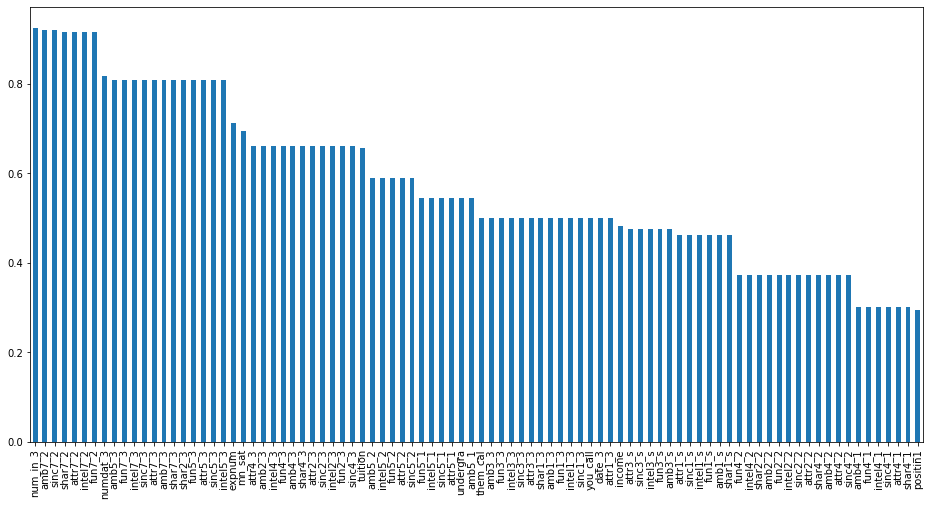

In [0]:
#percentage of missing by columns
NAN = 0.2 #threshold to drop
missing = data_df.isnull().sum()/len(data_df)
missing = missing[missing>0]
missing.sort_values(ascending=False,inplace=True)
plt.figure(figsize = (16,8))
missing[missing>NAN].plot.bar()
print('There are %0.0f variables with NaN' % len(missing))
print('{} variables have more than {} missing values out of {} rows'.format(len(missing[missing>NAN]),NAN ,len(data_df)))
print('Thus we are going to drop variables with more than {} NaNs'.format(NAN))

#After Processing all the fileds, drop NAN ones
var_to_drop = list(missing[missing>NAN].index)

not_remove = ['mn_sat','tuition','income']
for var in not_remove:
  var_to_drop.remove(var)

data_df = data_df.drop(var_to_drop,axis=1)

In [0]:
# How Many dates does each gender have?
num_dates_per_male = data_df[data_df.gender == 'Male'].groupby('iid').apply(len)
num_dates_per_female = data_df[data_df.gender == 'Female'].groupby('iid').apply(len)

In [0]:
# change string format number to float 2,300 => 2300.00
for trait in ['mn_sat', 'tuition', 'income']:
    data_df[trait] = str_to_float(data_df[trait])
    
data_df['pid'] = data_df['pid'].fillna(-1.0).astype('int64')  # Invalid PID as -1

Constructing additional features:

Financial: tuition + income. An indicator of the wealthiness of the family participants come from.

Experience: date + go_out. How often the participants are involved in social interaction. Giving a higher weight for dating.

Intelligence: mn_sat. The participants' undergrad mean sat score. Used in a way to represent the participants' 'intelligence level'.

In [0]:
# Create new features for modeling:
# 2.PROFILE OF THE PERSON
#     2.1 'tuition' + 'income' -> 'financial'

# fill out the nan in tuition and income to be mean value.
data_df['tuition']=data_df['tuition'].fillna(data_df['tuition'].mean())
data_df['income']=data_df['income'].fillna(data_df['income'].mean())

# Feature 1: financial
data_df['financial'] = (data_df['tuition']).add((data_df['income']))

# Feature 2: 'date' + 'go_out' -> 'experience' 
data_df['date']=data_df['date'].fillna(data_df['date'].mean())
data_df['go_out']=data_df['go_out'].fillna(data_df['go_out'].mean())
#different weights given to 'date' and 'go_out'
a=5
b=1
data_df['experience'] = a*data_df['date'] + b*data_df['go_out']
data_df['experience'] = data_df['experience']

# #Feature 3: 'mn_sat' -> 'intelligence'
data_df['int'] = data_df['mn_sat'];
data_df['int'] = data_df['int'].fillna(data_df['int'].mean())

Standardize and group up the features: pair-wise feature

Pair-wise features are mainly the difference, difference in personal features.

Similarity: field, career;
Difference: age + above personal features.
First, get the personal features that will be used in the calculation.

For nan: If the value is a difference, fill it with 0; If the value has a certain meaning (say age which can't be 0), fill it with the mean value.

In [0]:
# personal profile. To be read later when doing pair-wise feature.
profiles = data_df[['iid', 'int',  'field_cd', 'financial', 'experience','career_c']].set_index(keys='iid').drop_duplicates()
for trait in ['int', 'financial', 'experience']:
    profiles[trait] = profiles[trait].fillna(profiles[trait].mean)

# age difference 
data_df['age'] = data_df.groupby('gender')['age'].transform(lambda x: x.fillna(x.mean()))
data_df['age_o'] = data_df.groupby('gender')['age_o'].transform(lambda x: x.fillna(x.mean()))
data_df['age_diff'] = data_df['age'].sub(data_df['age_o'])  # Age difference = self - age of partner
data_df['age_diff'] = standardize_feature_2(data_df['age_diff']) 

f_age_mean = data_df[data_df.gender == 'Female']['age_diff'].mean()
m_age_mean = data_df[data_df.gender == 'Male']['age_diff'].mean()
print('average age diff for female {}'.format(f_age_mean))
print('average age diff for male {}'.format(m_age_mean))


average age diff for female -0.07909805368130442
average age diff for male 0.07559753866894797


In [0]:
# sum(data_df['age_diff'].isna())

In [0]:
# same field, true = 1, false = -1
def is_similar_profession(x, profiles):
    if np.isnan(x['field_cd']) or \
    np.isnan(x['pid']) or x['pid'] not in profiles.index or \
    x['field_cd'] != profiles.loc[x['pid']]['field_cd']:
        return -1
    else:
        return ((int(x['field_cd'] == profiles.loc[x['pid']]['field_cd']))-0.5)*2.0
    
data_df['sim_profession'] = data_df[['field_cd', 'pid']]\
                            .apply(lambda x: is_similar_profession(x, profiles), axis=1)
data_df['sim_profession'] = standardize_feature_2(data_df['sim_profession'])

In [0]:
#  same career, true = 1, false = -1
def is_similar_career(x, profiles):
    if np.isnan(x['career_c']) or \
    np.isnan(x['pid']) or x['pid'] not in profiles.index or\
        x['career_c'] != profiles.loc[x['pid']]['career_c']:
        return -1
    else:
        return ((int(x['career_c'] == profiles.loc[x['pid']]['career_c']))-0.5)*2.0
    
data_df['sim_career'] = data_df[['career_c', 'pid']]\
                            .apply(lambda x: is_similar_career(x, profiles), axis=1)
data_df['sim_career'] = standardize_feature_2(data_df['sim_career'])

In [0]:
# basic traits diffrence (standardized)
def trait_difference(trait):
    trait_other = data_df['pid'].apply(lambda x: profiles.loc[x][trait] if x in profiles.index else None)
    return data_df[trait].sub(trait_other)
    
# basic trait difference : male - female, intelligence, experience and financial
for trait in ['int','experience', 'financial']:
    string= trait + '_diff'
    data_df[string] = trait_difference(trait)
    data_df[string] = data_df[string].fillna(value=0) 
    data_df[string] = standardize_feature_2(data_df[string])

In [0]:
data_df.attr.describe().max

<bound method Series.max of count    6137.000000
mean        6.232508
std         1.934005
min         0.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        10.000000
Name: attr, dtype: float64>

**attr_exp** are attribues you feel which are more important in a date:

attr1_1:Attractive

sinc1_1:Sincere

intel1_1:Intelligent

fun1_1:Fun

amb1_1: Ambitious

shar1_1: Has shared interests/hobbies

all these fields add up to 100

Similarly, **attr_o** indicate how each participant rate their partners after each date. 

In [0]:
attr_exp = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
attr_o = ['attr', 'sinc', 'intel', 'fun', 'amb','shar']

# attr comes from original data, contains only the pair ids and attributes we need.
attr = data_df[['iid','gender','pid','attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1','shar1_1',\
               'attr', 'sinc', 'intel', 'fun', 'amb','shar' ]].set_index(keys='iid').drop_duplicates()

attr['attr1_sum']=attr[attr_exp].sum(axis=1)
attr['attr_sum']=attr[attr_o].sum(axis=1)

In [0]:
attr_exp_n = []
attr_o_n = []

for trait in attr_exp:
    attr[trait + '_n'] = attr[trait]/attr['attr1_sum'] 
    attr_exp_n.append(trait+'_n')
    
for trait in attr_o:
    attr[trait + '_n'] = attr[trait]/attr['attr_sum'] 
    attr_o_n.append(trait+'_n')

attr[attr_exp_n] = attr[attr_exp_n].fillna(value=1.0/5).astype('float64')
attr[attr_o_n] = attr[attr_o_n].fillna(value=1.0/5).astype('float64')

attr_m = attr[attr.gender == 'Male'];
attr_f = attr[attr.gender == 'Female'];


In [0]:
print(attr_exp_n)
print(attr_o_n)

['attr1_1_n', 'sinc1_1_n', 'intel1_1_n', 'fun1_1_n', 'amb1_1_n', 'shar1_1_n']
['attr_n', 'sinc_n', 'intel_n', 'fun_n', 'amb_n', 'shar_n']


In [0]:
attr.head()

,gender,pid,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr,sinc,intel,fun,amb,shar,attr1_sum,attr_sum,attr1_1_n,sinc1_1_n,intel1_1_n,fun1_1_n,amb1_1_n,shar1_1_n,attr_n,sinc_n,intel_n,fun_n,amb_n,shar_n
iid,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Female,11,15.0,20.0,20.0,15.0,15.0,15.0,6.0,9.0,7.0,7.0,6.0,5.0,100.0,40.0,0.15,0.2,0.2,0.15,0.15,0.15,0.150000,0.225000,0.175000,0.175000,0.150000,0.125000
1,Female,12,15.0,20.0,20.0,15.0,15.0,15.0,7.0,8.0,7.0,8.0,5.0,6.0,100.0,41.0,0.15,0.2,0.2,0.15,0.15,0.15,0.170732,0.195122,0.170732,0.195122,0.121951,0.146341
1,Female,13,15.0,20.0,20.0,15.0,15.0,15.0,5.0,8.0,9.0,8.0,5.0,7.0,100.0,42.0,0.15,0.2,0.2,0.15,0.15,0.15,0.119048,0.190476,0.214286,0.190476,0.119048,0.166667
1,Female,14,15.0,20.0,20.0,15.0,15.0,15.0,7.0,6.0,8.0,7.0,6.0,8.0,100.0,42.0,0.15,0.2,0.2,0.15,0.15,0.15,0.166667,0.142857,0.190476,0.166667,0.142857,0.190476
1,Female,15,15.0,20.0,20.0,15.0,15.0,15.0,5.0,6.0,7.0,7.0,6.0,6.0,100.0,37.0,0.15,0.2,0.2,0.15,0.15,0.15,0.135135,0.162162,0.189189,0.189189,0.162162,0.162162


In [0]:
attr['attr_sum'].describe()

count    6266.000000
mean       37.447638
std        10.371539
min         0.000000
25%        32.000000
50%        39.000000
75%        44.000000
max        60.000000
Name: attr_sum, dtype: float64

In [0]:
# divide them into female data and male data
data_df_m = data_df[data_df.gender == 'Male'] #data of male
data_df_f = data_df[data_df.gender == 'Female'] #data of female

In [0]:
df_train = data_df_m[['iid','pid','match', 'age_diff','sim_profession','sim_career','int_diff','experience_diff','financial_diff']]

In [0]:
df_train['rating'] = np.zeros(len(df_train)) #create the all 0 values for rating

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
for i in attr_m.index.drop_duplicates(): #index is male iid
    for j in attr_m.loc[i].pid: #pid is partner female (partner) iid
        # (i,j) makes a pair
        temp1=0
        temp2=0
        temp3=0
        for k in np.arange(0,5):
            if i not in attr_m.index or \
                j not in attr_f.index:
                temp1 = 0
                temp2 = 0
            else:
                temp1 = attr_m.loc[attr_m['pid']==j].loc[i][attr_exp_n[k]] #for the pair (i,j) how important i think k attributes in the date with j
                temp2 = attr_f.loc[attr_f['pid']==i].loc[j][attr_o_n[k]] #for the pair (i,j) how much i rate j for k attributes in the date
            temp3 += temp1*temp2 #rating = importance * rates
        get_index = df_train.loc[df_train['iid']==i].loc[df_train['pid']==j].index
        df_train.at[get_index, 'rating'] = temp3

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
final=df_train.copy()

#### Up Sampling the Minority

In [0]:
#Upsample the minority 
from sklearn.utils import resample

df_majority = final[final.match==0]
df_minority = final[final.match==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=1700,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.match.value_counts()

0    2603
1    1700
Name: match, dtype: int64

####Save Preprocessed Data

In [0]:
final.to_csv('drive/My Drive/1007Project/'+"/processed.csv") 
df_upsampled.to_csv('drive/My Drive/1007Project/'+"/processed_UpSample.csv") 
#save the fimle onto dirve so we could use it directly next time

####Read in Preprocessed Data

In [0]:
final = pd.read_csv('drive/My Drive/1007Project/'+"/processed.csv")
df_upsampled = pd.read_csv('drive/My Drive/1007Project/'+"/processed_UpSample.csv") 

####Train Test Split

In [0]:
y = final['match']
X = final.drop(['match','iid','pid'],axis=1)
print('There are {} records in the data'.format(len(final)))
X.head()

There are 3138 records in the data


,Unnamed: 0,Unnamed: 0.1,age_diff,sim_profession,sim_career,int_diff,experience_diff,financial_diff,rating
0,0,100,1.278594,-1.597256,-1.315691,0.0,-0.678139,-1.377593,0.167500
1,1,101,0.639297,-1.597256,-1.315691,0.0,0.290631,-1.174460,0.168182
2,2,102,0.426198,-1.597256,-1.315691,0.0,1.259401,0.000000,0.153000
3,3,103,0.852396,-1.597256,-1.315691,0.0,0.290631,0.434106,0.142857
4,4,104,1.278594,-1.597256,-1.315691,0.0,0.775016,-2.339763,0.198148


In [0]:
ys = df_upsampled['match']
Xs = df_upsampled.drop(['match','iid','pid'],axis=1)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)

##Models

### **Logistic Regression Modeling**

As the first part of modeling, we decided to choose Logistic Regression as our first classifier to see how this algorithm would perform on predicting the speed dating result. After the train data was fitted into the model, we got the evaluation of this model by looking at accuracy, confusion matrix, and ROC-AUC. 

In [0]:
# Fit the data into logistic model
classifier = LogisticRegression() 
logmodel=classifier.fit(X_train, y_train) 
ytr_pred=logmodel.predict(X_train) 
y_pred = logmodel.predict(X_test) 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
# Evaluation Metrics
from sklearn.metrics import accuracy_score 
print ("Train Accuracy : ", accuracy_score(y_train, ytr_pred)) 
print ("Test Accuracy : ", accuracy_score(y_test, y_pred)) 

Train Accuracy :  0.8282868525896414
Test Accuracy :  0.8343949044585988


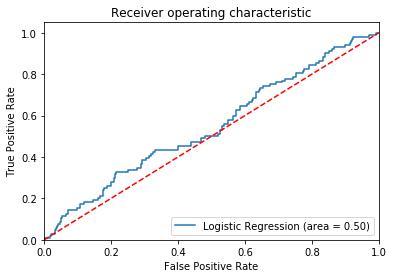

In [0]:
# ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logmodel.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print("confusion matrix: ")
print(confusion_matrix)

confusion matrix: 
[[524   0]
 [104   0]]


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       524
           1       0.00      0.00      0.00       104

    accuracy                           0.83       628
   macro avg       0.42      0.50      0.45       628
weighted avg       0.70      0.83      0.76       628



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


According to these evaluation metrics, it is clear that our model does not reach the expectation although the the accuracy on test data reaches 0.83. The confusion matrix indicates that the model correctly predicts all 0 while also incorrectly classifies all 1 as 0, which means our model actually classify all samples as 0s. And by looking at the ROC curve, the AUC has only 0.5. Such an outcome might be attributed to the data imbalance if our training data is actually containing many more samples with 0 than samples with 1.

#### Improve the model with upsample minority


In [0]:
final['match'].value_counts()

0    2603
1     535
Name: match, dtype: int64

Having recognized the potential existence of huge data imbalance, we then went back to check the data distribution and found that were over 2600 samples with 0 in match, but only 500 samples with 1. Therefore, we tried to apply up-sampling the minority class to make the data balanced. We up-sampled the minority class(match=1) to 1700 and refitted new training data into the logistic model. 

In [0]:
# Refit the data into logistic model
classifier = LogisticRegression() 
logmodel=classifier.fit(Xs_train, ys_train) 
ytrs_pred=logmodel.predict(Xs_train) 
ys_pred = logmodel.predict(Xs_test) 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
# Evaluation Metrics
from sklearn.metrics import accuracy_score 
print ("Train Accuracy : ", accuracy_score(ys_train, ytrs_pred)) 
print ("Test Accuracy : ", accuracy_score(ys_test, ys_pred)) 

Train Accuracy :  0.5952934340499709
Test Accuracy :  0.645760743321719


In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(ys_test, ys_pred)
print("confusion matrix: ")
print(confusion_matrix)

confusion matrix: 
[[542  16]
 [289  14]]


In [0]:
from sklearn.metrics import classification_report
print(classification_report(ys_test, ys_pred))

              precision    recall  f1-score   support

           0       0.65      0.97      0.78       558
           1       0.47      0.05      0.08       303

    accuracy                           0.65       861
   macro avg       0.56      0.51      0.43       861
weighted avg       0.59      0.65      0.54       861



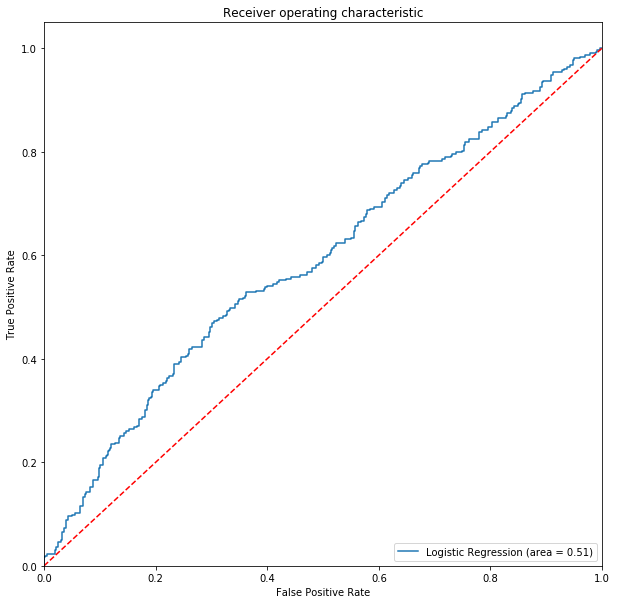

In [0]:
# ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(ys_test, logmodel.predict(Xs_test))
fpr, tpr, thresholds = roc_curve(ys_test, logmodel.predict_proba(Xs_test)[:,1])
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()



Now the new confusion matrix is telling that the model does not simply predict everything as 0 anymore, even though the accuracy of correctly predicting 1 is still quite low. Besides, the ROC curve also shows a slight improvement and AUC increases to 0.51 from 0.50. The general test accuracy approximates 0.65, which indicates that the logistic model is able to correctly predict \%65 samples from test set. However, we do not consider it as a good model due to the poor performance.

### **Decision Tree modeling on original data**

#### baseline

Aside from Logistic Regression, we also wanted to study the ability of a non-parametric model in fitting our data. A decision tree is a largely used non-parametric effective machine learning modeling technique for classification problems, which suits our problem. We will begin by fitting a simple decision tree classifier on our training data with no parameter tuning as our baseline model. We will perform prediction on the test data and evaluate the model performance.

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
# base model with no parameter tuning

# Create Decision Tree classifer object
dtclf1 = DecisionTreeClassifier()

# Train Decision Tree Classifer
dtclf1 = dtclf1.fit(X_train,y_train)

#Predict the response for test dataset
dt_y_pred1 = dtclf1.predict(X_test)
dt_y_tr_pred1 = dtclf1.predict(X_train)

In [0]:
# Evaluation Metrics
from sklearn.metrics import accuracy_score  
print ("Base Model Test Accuracy : ", accuracy_score(y_train, dt_y_tr_pred1)) 
print ("Base Model Test Accuracy : ", accuracy_score(y_test, dt_y_pred1)) 

dt_y_score1 = dtclf1.predict_proba(X_test)[:,1]
dt_AUC1 = roc_auc_score(y_test, dt_y_score1)
print('Base Model AUC:', dt_AUC1)

Base Model Test Accuracy :  1.0
Base Model Test Accuracy :  0.6815286624203821
Base Model AUC: 0.48546682325308277


From our evaluation, we can see that our baseline model gives an accuracy of about 68.15% on the test data. This accuracy might not seem that inaccurate, however, when evluating the AUC of our predictions, we get a score of only 0.48 which is extremely bad. Further tuning of parameters is definitely needed.

#### plot our baseline tree

In [0]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(dtclf1, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('base_dt.png')
Image(graph.create_png())

This is the tree-diagram of our basleine decision tree. Since we did not impose any parameter restrictions, our tree is very extensive and splits until purity is reach or when there is only 2 samples left in a leaf node. 

#### try some parameter tuning

As a demonstration of parameter tuning, we naively choose to restrict two parameters in the decision tree classifier and observe their effects on the model. Specifially, we set the splitting criterion to entropy and the maximum depth of our tree to 3.

In [0]:
# model with some parameter tuning

# Create Decision Tree classifer object
dtclf2 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)

# Train Decision Tree Classifer
dtclf2 = dtclf2.fit(X_train,y_train)

#Predict the response for test dataset
dt_y_pred2 = dtclf2.predict(X_test)
dt_y_tr_pred2 = dtclf2.predict(X_train)

In [0]:
# Evaluation Metrics
from sklearn.metrics import accuracy_score  
print ("2nd Model Train Accuracy : ", accuracy_score(y_train, dt_y_tr_pred2)) 
print ("2nd Model Test Accuracy : ", accuracy_score(y_test, dt_y_pred2))

dt_y_score2 = dtclf2.predict_proba(X_test)[:,1]
dt_AUC2 = roc_auc_score(y_test, dt_y_score2)
print('2nd Model AUC:', dt_AUC2)

2nd Model Train Accuracy :  0.8282868525896414
2nd Model Test Accuracy :  0.8343949044585988
2nd Model AUC: 0.4957795067527892


As we can see, our 2nd model largely increased our accuracy and slighly increased our AUC, which should indicate that this model is better than our baseline. We further look into the cause of this huge increase in accuracy.

In [0]:
dt_y_pred2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [0]:
y_test[y_test == 0].count() / y_test.count()

0.8343949044585988

Although our second model did increase in precision, it is only because after limiting the depth of the model to 3, it can only classify all classes as 0, and since our true `y_test` have about 83,4394% 0's, we got lucky and got 83% accuracy. This doesn't mean that our model is better, it is actually worse in prediction power because no matter what data you feed into it, you will only get class 0 as a prediction.

#### plot our 2nd decision tree model

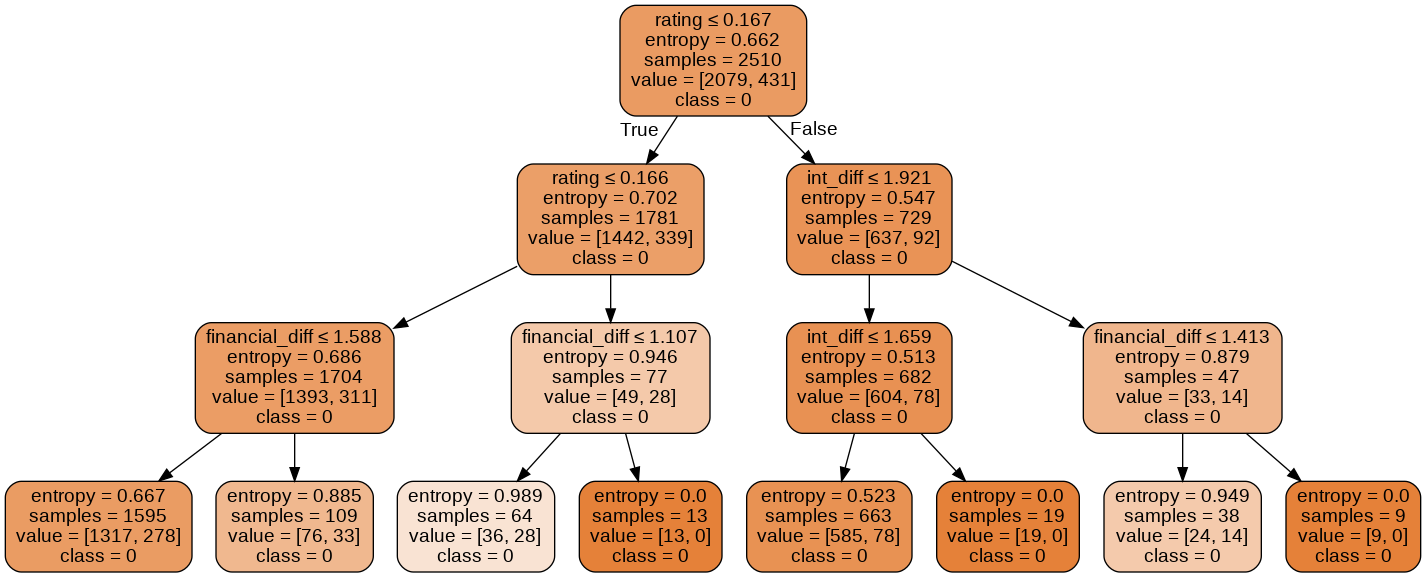

In [0]:
dot_data = StringIO()
export_graphviz(dtclf2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('2nd_dt.png')
Image(graph.create_png())

Since we have restrictd the maximum depth of our tree to 3, we get a much simpler tree model than our baseline. This model comfired that all leaf nodes are classified as class 0

#### grid search on decision tree on upsampled data

The initial naive implementation of parameter tuning shows the potential of increasing model performance. If we can try such parameter tuning with many different values and compare model performance at once, we can find the parameters that give the best model as a result. With this goal in mind, we perform a grid search on our decision tree model where we try all values from 5 to 100 as our maximum depth and both 'gini' and 'entropy' as our splitting criterion in hopes of finding the best combination.

In [0]:
# Create Decision Tree classifer object
dtclf3 = DecisionTreeClassifier()

In [0]:
# lets try many different vales as our max_depth and see which one yields the highest AUC
# Import
from sklearn.model_selection import GridSearchCV

# Define the parameter values that should be searched
max_depth_range = list(range(5, 100))

# Create a parameter grid: map the parameter names to the values that should be searched
# Simply a python dictionary
# Key: parameter name
# Value: list of values that should be searched for that parameter
# Single key-value pair for param_grid
dt_param_grid = dict(max_depth=max_depth_range, criterion = ['gini', 'entropy'])

# instantiate the grid
dt_grid = GridSearchCV(dtclf3, dt_param_grid, cv=5, scoring='roc_auc')

# fit the grid with data
dt_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,

In [0]:
# examine the best model

# Single best score achieved across all params (max_depth)
print("the best score we got:" , dt_grid.best_score_)

# Dictionary containing the parameters (max_depth) used to generate that score
print("the best parameters are:",dt_grid.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print("the best model is:",dt_grid.best_estimator_)

the best score we got: 0.5572288175567074
the best parameters are: {'criterion': 'entropy', 'max_depth': 5}
the best model is: DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


#### final model after grid search

From our grid search, we can see that the combination which results in the best model performance is when we set the splitting criterion to 'entropy' and the maximum tree depth to 5. We fit our model model with these parameters.

In [0]:
# final model with parameters 'entropy' and 5 as max_depth, which was the optimal parameters concluded from 
# un-upsampled data

# Create Decision Tree classifer object
dtclf_f = DecisionTreeClassifier(class_weight=None, criterion=dt_grid.best_params_['criterion'], 
                       max_depth=dt_grid.best_params_['max_depth'],
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

# Train Decision Tree Classifer
dtclf_f = dtclf_f.fit(X_train,y_train)

#Predict the response for test dataset
dt_y_pred_f = dtclf_f.predict(X_test)
dt_y_tr_pred_f = dtclf_f.predict(X_train)

In [0]:
# Evaluation Metrics
print ("Final Model Train Accuracy : ", accuracy_score(y_train, dt_y_tr_pred_f)) 
print ("Final Model Test Accuracy : ", accuracy_score(y_test, dt_y_pred_f)) 

dt_y_score_f = dtclf_f.predict_proba(X_test)[:,1]
dt_AUC_f = roc_auc_score(y_test, dt_y_score_f)
print('Final Model AUC:', dt_AUC_f)

Final Model Train Accuracy :  0.8362549800796812
Final Model Test Accuracy :  0.8105095541401274
Final Model AUC: 0.5063949647680563


In [0]:
AUC_inc_perc = (dt_AUC_f - dt_AUC1) / dt_AUC1
AUC_inc_perc

0.043109313577260354

We can see that after our final parameter tuning, we get an accuracy of about 81.05%, which is different than the 83% we got from the "lucky" guess. Our AUC score has increased 4.31%, which is slight but still non-trivial.

#### plot our final decision tree model

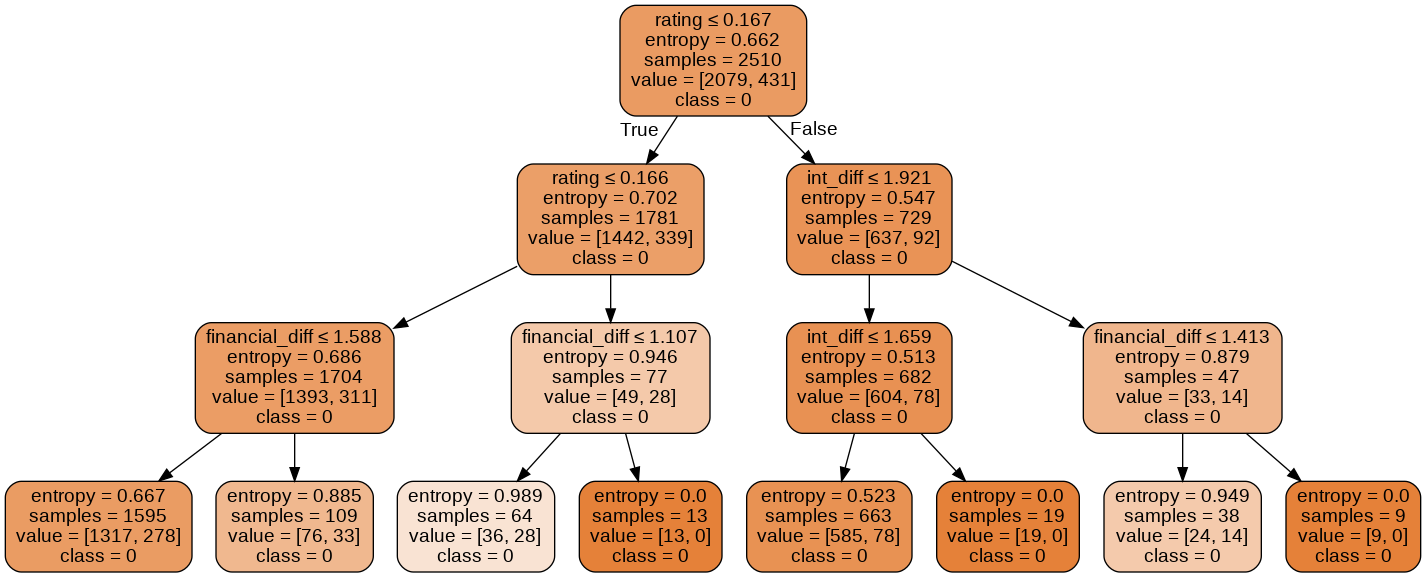

In [0]:
dot_data = StringIO()
export_graphviz(dtclf2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('final_dt.png')
Image(graph.create_png())

## **Decision Tree modeling on upsampled data**

From fitting the Logistic Regression model, we have observed that by upsampling out data, model can increase performance. Thus, it is only reasonable to see if training our decision tree model with upsampled data can increase performance as well.

#### baseline tree for upsampled data

Again, we begin with a simple decision tree classifier with all default parameters as a baseline.

In [0]:
# base model with no parameter tuning

# Create Decision Tree classifer object
dtclf1s = DecisionTreeClassifier()

# Train Decision Tree Classifer
dtclf1s = dtclf1.fit(Xs_train,ys_train)

#Predict the response for test dataset
dt_y_pred1s = dtclf1.predict(Xs_test)
dt_y_tr_pred1s = dtclf1.predict(Xs_train)

In [0]:
# Evaluation Metrics
from sklearn.metrics import accuracy_score  
print ("Base Model with upsample Test Accuracy : ", accuracy_score(ys_train, dt_y_tr_pred1s)) 
print ("Base Model with upsample Test Accuracy : ", accuracy_score(ys_test, dt_y_pred1s)) 

dt_y_score1s = dtclf1s.predict_proba(Xs_test)[:,1]
dt_AUC1s = roc_auc_score(ys_test, dt_y_score1s)
print('Base Model AUC:', dt_AUC1s)

Base Model with upsample Test Accuracy :  1.0
Base Model with upsample Test Accuracy :  0.8397212543554007
Base Model AUC: 0.8582455019695517


We can wee that, just for our baseline model, we get a significant better AUC score, showing that by upsampling our data, we can greatly improve model performance.

#### plot upsampled baseline tree

In [0]:
dot_data = StringIO()
export_graphviz(dtclf1, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('base_dt_ups.png')
Image(graph.create_png())

#### grid search on upsampled data

We perform another grid search testing the same range of values for our parameters, 5 to 100 for maximum depth and both 'entropy' and 'gini' for splitting criterion, for our model, but this time, we train and test performance on upsampled data.

In [0]:
# Create Decision Tree classifer object
dtclf4 = DecisionTreeClassifier()

# Define the parameter values that should be searched
max_depth_range = list(range(5, 100))

# Create a parameter grid: map the parameter names to the values that should be searched
# Simply a python dictionary
# Key: parameter name
# Value: list of values that should be searched for that parameter
# Single key-value pair for param_grid
dt_param_grid = dict(max_depth=max_depth_range, criterion = ['gini', 'entropy'])

# instantiate the grid
dt_grid = GridSearchCV(dtclf4, dt_param_grid, cv=5, scoring='roc_auc')

# fit the grid with data
dt_grid.fit(Xs_train, ys_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,

In [0]:
# examine the best model

# Single best score achieved across all params (max_depth)
print("the best score we got:" , dt_grid.best_score_)

# Dictionary containing the parameters (max_depth) used to generate that score
print("the best parameters are:",dt_grid.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print("the best model is:",dt_grid.best_estimator_)

the best score we got: 0.8376886586545097
the best parameters are: {'criterion': 'entropy', 'max_depth': 79}
the best model is: DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=79,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


From our grid search, we find that the best splitting criterion is 'entropy' and the best maximum depth is 79. We uses these parameters to fit our final model.

#### fit final model on upsampled data

In [0]:
# final model with upsampled data

# Create Decision Tree classifer object
dtclf_fs = DecisionTreeClassifier(class_weight=None, criterion=dt_grid.best_params_['criterion'], 
                       max_depth=dt_grid.best_params_['max_depth'],
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

# Train Decision Tree Classifer
dtclf_fs = dtclf_fs.fit(Xs_train,ys_train)

#Predict the response for test dataset
dt_y_pred_fs = dtclf_fs.predict(Xs_test)
dt_y_tr_pred_fs = dtclf_fs.predict(Xs_train)

In [0]:
# Evaluation Metrics
print ("Final Model with upsample Train Accuracy : ", accuracy_score(ys_train, dt_y_tr_pred_fs)) 
print ("Final Model with upsample Test Accuracy : ", accuracy_score(ys_test, dt_y_pred_fs)) 

dt_y_score_fs = dtclf_fs.predict_proba(Xs_test)[:,1]
dt_AUC_fs = roc_auc_score(ys_test, dt_y_score_fs)
print('Final Model with upsample AUC:', dt_AUC_fs)

Final Model with upsample Train Accuracy :  1.0
Final Model with upsample Test Accuracy :  0.8478513356562137
Final Model with upsample AUC: 0.8682884417474006


In [0]:
AUC_inc_percs = (dt_AUC_fs - dt_AUC1s) / dt_AUC1s
AUC_inc_percs

0.011701709772788492

In [0]:
total_AUC_inc_perc = (dt_AUC_fs - dt_AUC1) / dt_AUC1
total_AUC_inc_perc

0.788563914479375

From our model with parameter restrictions, we have increased our AUC by 1.17%, which is insignificant but non-trivial. Overall, from our initial baseline, through upsamling and parameter tuning, we have increase our AUC by 78.86%, which indicates a huge increase in model performance. Our final model trained on the upsampled data with entropy as a splitting criterion and 79 as maximum depth results in a test accuracy of 84.78%, which shows that our model fits the data set very well.

#### get feature importances from the best upsampled model

In [0]:
dt_imp_arrs = dtclf_fs.feature_importances_

In [0]:
dt_imp_fs = pd.Series(dt_imp_arrs, index = Xs_train.columns)
dt_imp_fs

age_diff           0.112283
sim_profession     0.026397
sim_career         0.015698
int_diff           0.111271
experience_diff    0.150642
financial_diff     0.253050
rating             0.330659
dtype: float64

In [0]:
dt_imp_fs.sort_values(ascending = False)

rating             0.330659
financial_diff     0.253050
experience_diff    0.150642
age_diff           0.112283
int_diff           0.111271
sim_profession     0.026397
sim_career         0.015698
dtype: float64

From our best decision tree model, we have computed the feature impotance for each of the 7 features in our data. The features that ranks from having th emost impact on the outcome of speed dating to the least are:
1. rating
2. financial difference
3. experience difference
4. age difference
5. intelligence differece
6. similarity of profession
7. similarity of intended career choice

From this result, we can see that having a good rating, which means that leaving good impressions on the attributes that ranks as more imporant to your date, impacts the outcome of speed dating the most. 

#### plot final tree with upsampled data

In [0]:
dot_data = StringIO()
export_graphviz(dtclf1, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('final_dt_ups.png')
Image(graph.create_png())

## **XGB Modeling**






In [0]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn.metrics import confusion_matrix

###Baseline Model with no parameters tuning

In [0]:
model_v1 = GradientBoostingClassifier()
xgb_model_v1 = model_v1.fit(X_train, y_train)
predict_train_xgb_base_v1 = xgb_model_v1.predict(X_train)
predict_test_xgb_base_v1 = xgb_model_v1.predict(X_test)
AUC_xgb_base_v1 = roc_auc_score(y_test, predict_test_xgb_base_v1)
print('Base Model Training Accuracy:', 
      metrics.accuracy_score(y_train, predict_train_xgb_base_v1))
print('Base Model Validation Accuracy:', 
      metrics.accuracy_score(y_test, predict_test_xgb_base_v1))
print('Base Model AUC:', AUC_xgb_base_v1)

Base Model Training Accuracy: 0.8466135458167331
Base Model Validation Accuracy: 0.8343949044585988
Base Model AUC: 0.5154139753376394


In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_v1 = confusion_matrix(y_test, predict_test_xgb_base_v1)
print("confusion matrix: ")
print(confusion_matrix_v1)

confusion matrix: 
[[520   4]
 [100   4]]


In [0]:
model_v11 = GradientBoostingClassifier()
xgb_model_v11 = model_v11.fit(Xs_train, ys_train)
predict_train_xgb_base_v11 = xgb_model_v11.predict(Xs_train)
predict_test_xgb_base_v11 = xgb_model_v11.predict(Xs_test)
AUC_xgb_base_v11 = roc_auc_score(ys_test, predict_test_xgb_base_v11)
print('Base Model Training Accuracy:', 
      metrics.accuracy_score(ys_train, predict_train_xgb_base_v11))
print('Base Model Validation Accuracy:', 
      metrics.accuracy_score(ys_test, predict_test_xgb_base_v11))
print('Base Model AUC:', AUC_xgb_base_v11)

Base Model Training Accuracy: 0.7649622312608948
Base Model Validation Accuracy: 0.7224157955865272
Base Model AUC: 0.6387912984846872


In [0]:
# Confusion Matrix
confusion_matrix_v11 = confusion_matrix(ys_test, predict_test_xgb_base_v11)
print("confusion matrix: ")
print(confusion_matrix_v11)

confusion matrix: 
[[514  44]
 [195 108]]


###**HyperParameter Tuning: Grid Search on Original Data**

In [0]:
param_test2 = {
 'learning_rate':np.linspace(0.05,0.3,5).tolist(),
 'n_estimators': range(10,110,5),
 'subsamples':np.linspace(0.1,1,5).tolist()
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, 
                                      subsample=0.8, 
                                      objective= 'binary:logistic'), 
                        param_grid = param_test1, 
                        n_jobs=4,iid=False, cv=5)

eval_set = [(X_test, y_test)]
gsearch2.fit(X_train,y_train,
             early_stopping_rounds=10,
                            eval_metric="error",eval_set=eval_set,
                            verbose=True)

[0]	validation_0-error:0.160828
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.16242
[2]	validation_0-error:0.164013
[3]	validation_0-error:0.165605
[4]	validation_0-error:0.164013
[5]	validation_0-error:0.167197
[6]	validation_0-error:0.165605
[7]	validation_0-error:0.167197
[8]	validation_0-error:0.167197
[9]	validation_0-error:0.165605


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'learning_rate': [0.05, 0.1125, 0.175, 0.2375, 0.3],
                         'n_estimators': range(10, 110, 5),
                         'subsa

In [0]:
print('Best hyperparameter for the XGB based on training sample is:')
gsearch2.best_params_, gsearch2.best_score_

Best hyperparameter for the XGB based on training sample is:


({'learning_rate': 0.2375, 'n_estimators': 10, 'subsamples': 0.1},
 0.827492936157261)

In [0]:
model_v2 = XGBClassifier(learning_rate =0.2375, n_estimators=10, 
                          subsample=0.1)
eval_set = [(X_test, y_test)]
xgb_model_v2 = model_v2.fit(X_train, y_train,
                            early_stopping_rounds=10,
                            eval_metric="error",eval_set=eval_set,
                            verbose=True)

predict_train_xgb_v2 = xgb_model_v2.predict(X_train)
predict_test_xgb_v2 = xgb_model_v2.predict(X_test)
AUC_xgb_v2 = roc_auc_score(y_test, predict_test_xgb_v2)

print('Model Training Accuracy: {}'.format(metrics.accuracy_score(y_train, predict_train_xgb_v2)))
print('Model Validation Accuracy:', metrics.accuracy_score(y_test, predict_test_xgb_v2))
print('Model AUC:', AUC_xgb_v2)

[0]	validation_0-error:0.254777
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.194268
[2]	validation_0-error:0.181529
[3]	validation_0-error:0.170382
[4]	validation_0-error:0.178344
[5]	validation_0-error:0.175159
[6]	validation_0-error:0.170382
[7]	validation_0-error:0.170382
[8]	validation_0-error:0.176752
[9]	validation_0-error:0.173567
Model Training Accuracy: 0.8270916334661355
Model Validation Accuracy: 0.8296178343949044
Model AUC: 0.5009908984145625


In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_v2 = confusion_matrix(y_test, predict_test_xgb_v2)
print("confusion matrix: ")
print(confusion_matrix_v2)

confusion matrix: 
[[520   4]
 [103   1]]


###HyperParameter Tuning: Grid Search on Up Sample Data

In [0]:
param_test3 = {
 'learning_rate':np.linspace(0.05,0.3,5).tolist(),
 'n_estimators': range(10,110,5),
 'subsamples':np.linspace(0.1,1,5).tolist()
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, 
                                      subsample=0.8, 
                                      objective= 'binary:logistic'), 
                        param_grid = param_test1, 
                        n_jobs=4,iid=False, cv=5)

eval_set = [(Xs_test, ys_test)]
gsearch3.fit(Xs_train,ys_train,
             early_stopping_rounds=10,
                            eval_metric="error",eval_set=eval_set,
                            verbose=True)

[0]	validation_0-error:0.347271
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.337979
[2]	validation_0-error:0.337979
[3]	validation_0-error:0.339141
[4]	validation_0-error:0.326365
[5]	validation_0-error:0.328688
[6]	validation_0-error:0.325203
[7]	validation_0-error:0.317073
[8]	validation_0-error:0.31475
[9]	validation_0-error:0.317073
[10]	validation_0-error:0.318235
[11]	validation_0-error:0.317073
[12]	validation_0-error:0.313589
[13]	validation_0-error:0.307782
[14]	validation_0-error:0.305459
[15]	validation_0-error:0.29849
[16]	validation_0-error:0.29849
[17]	validation_0-error:0.29849
[18]	validation_0-error:0.288037
[19]	validation_0-error:0.291521
[20]	validation_0-error:0.29036
[21]	validation_0-error:0.285714
[22]	validation_0-error:0.285714
[23]	validation_0-error:0.293844
[24]	validation_0-error:0.296167
[25]	validation_0-error:0.293844
[26]	validation_0-error:0.296167
[27]	validation_0-error:0.297329
[28]	validation_0-error:0

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'learning_rate': [0.05, 0.1125, 0.175, 0.2375, 0.3],
                         'n_estimators': range(10, 110, 5),
                         'subsa

In [0]:
print('Best hyperparameter for the XGB based on upsamlpe training data is:')
gsearch3.best_params_, gsearch3.best_score_

Best hyperparameter for the XGB based on upsamlpe training data is:


({'learning_rate': 0.2375, 'n_estimators': 75, 'subsamples': 0.1},
 0.7074319877139096)

In [0]:
model_v3 = XGBClassifier(learning_rate =0.2375, n_estimators=75, 
                          subsample=0.1,objective= 'binary:logistic')

eval_set = [(Xs_test, ys_test)]
xgb_model_v3 = model_v3.fit(Xs_train, ys_train,
                            early_stopping_rounds=10,
                            eval_metric="error",eval_set=eval_set,
                            verbose=True)

predict_train_xgb_v3 = xgb_model_v3.predict(Xs_train)
predict_test_xgb_v3 = xgb_model_v3.predict(Xs_test)
AUC_xgb_v3 = roc_auc_score(ys_test, predict_test_xgb_v3)

print('Model Training Accuracy: {}'.format(metrics.accuracy_score(ys_train, predict_train_xgb_v3)))
print('Model Validation Accuracy:', metrics.accuracy_score(ys_test, predict_test_xgb_v3))
print('Model AUC:', AUC_xgb_v3)

[0]	validation_0-error:0.341463
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.346109
[2]	validation_0-error:0.364692
[3]	validation_0-error:0.347271
[4]	validation_0-error:0.343786
[5]	validation_0-error:0.347271
[6]	validation_0-error:0.344948
[7]	validation_0-error:0.344948
[8]	validation_0-error:0.328688
[9]	validation_0-error:0.342625
[10]	validation_0-error:0.337979
[11]	validation_0-error:0.343786
[12]	validation_0-error:0.337979
[13]	validation_0-error:0.351916
[14]	validation_0-error:0.361208
[15]	validation_0-error:0.360046
[16]	validation_0-error:0.353078
[17]	validation_0-error:0.353078
[18]	validation_0-error:0.347271
Stopping. Best iteration:
[8]	validation_0-error:0.328688

Model Training Accuracy: 0.6330621731551423
Model Validation Accuracy: 0.6713124274099884
Model AUC: 0.5714627914404344


In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_v3 = confusion_matrix(ys_test, predict_test_xgb_v3)
print("confusion matrix: ")
print(confusion_matrix_v3)

confusion matrix: 
[[507  51]
 [232  71]]


When we only use 7 features and limited data, compared to the other two models, XGboost tends to underperforma and more prone to overfitting

# Discussion

## Conclusion from findings

According to our findings, we would choose Decision Tree Classifier as our preferred model on this case. Compared with the other 2 models, Decision Tree model demonstrates its outstanding performance with the final accuracy of 84.7% and the AUC of 78.9%. Besides, both Logistic Regression model and XGB model increased their AUC after upsampling the data although their accuracy went down. This is probably due to the fact that the amount of samples with 0 as the target class seriously overwhelms the amount of samples with 1 as the target class, discrediting our accuracies obtained from models using the original data.  In the basleine cases, we obtained better accuracies with the data, but it can not support the fact that model performances were better. Therefore, when models get trained by the upsampled data, classifiers are finally able to predict samples with 1 as the target varaible with an accuracy that we can trust more.

According to the final outcome of the Decision Tree model, 7 features are ordered by their importance to the target variable: rating, financial difference, experience difference, age difference, intelligence differece, similarity of profession, similarity of intended career choice. Therefore, based on our data resource, we found that the successful rate of speed dating would be mostly influenced by the comprehensive rating, financial difference and experience difference of both sides.

## Possible next steps

For the future improvement, it is of necessity to enlarge the data size. Our current data only contains about 4000 samples, which is barely enough to get a good model by training. It might be part of the reason why Logistic Regression and XGBoosting models do not reach our expected performance.